# Homework 1. Binary classification metrics.
In this homework assignment, you are asked to implement several binary classification metrics and find out if the new model will be useful in production.
`model_v1_preds.csv` and `model_v2_preds.csv` contains predictions of current best production model and freshly trained one on test set. Test set was obtained this way:
1. Matches we can find with our production models was excluded from candidates set.
2. 5 categories was chosen: `Детские товары`, `Дом и сад`, `Строительство и ремонт`, `Товары для взрослых`, `Хобби и творчество`.
3. A 10k sample was taken from each category.
4. 50k pairs was labeled in crowd system (specially trained people answered the question of whether a pair of products is a match).

In [1]:
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc, precision_recall_curve, roc_auc_score

In [2]:
### load models predictions
model_v1_preds = pd.read_csv("model_v1_preds.csv")
model_v2_preds = pd.read_csv("model_v2_preds.csv")

### load real labels
real_labels = pd.read_csv("real_labels.csv")

In [3]:
real_labels["cat2"].value_counts()

Дом и сад                 9001
Хобби и творчество        8954
Строительство и ремонт    8905
Детские товары            8667
Товары для взрослых       7895
Name: cat2, dtype: int64

## Task 1. ROC AUC.

### Point estimate
Implement [ROC AUC](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) metric, apply it to both models' predictions, compare with metric values of `sklearn.metrics.roc_auc_score`.
You can use `sklearn.metrics.auc` to calculate area under the curve. You just need to get coordinates of the points of the curve.

In [4]:
def roc_auc_home_made(real_labels, preds):
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])
    
    # get normalization terms
    labels_counts = df["target"].value_counts().to_dict()
    biggest_tp_cnt = labels_counts[1]  # normalization term for y
    biggest_fp_cnt = labels_counts[0]  # normalization term for x

    # sort df in descending order of predictions
    df = df.sort_values(by="score", ascending=False)
    
    # first point is (0, 0)
    curve_coordinates = [(0, 0)]
    x, y = 0, 0

    i = 0
    while i < df.shape[0]:
        if i == df.shape[0] - 1:
            # last point is (1, 1)
            curve_coordinates.append((1, 1))
            i += 1
        
        # if scores differs curve will go either up or right
        elif df.iloc[i]["score"] != df.iloc[i+1]["score"]:

            if df.iloc[i]["target"] == 1:
                y += 1
            else:
                x += 1

            curve_coordinates.append((x/biggest_fp_cnt, y/biggest_tp_cnt))
            i += 1

        # if scores are equal and targets differ curve will go diagonally
        else:
            labels_counts = {0: 0, 1: 0}
            
            while df.iloc[i]["score"] == df.iloc[i+1]["score"]:
                labels_counts[df.iloc[i]["target"]] += 1
                i += 1
                if i == df.shape[0] - 1:
                    break
            
            labels_counts[df.iloc[i]["target"]] += 1
            i += 1
            
            x += labels_counts[0]
            y += labels_counts[1]

            curve_coordinates.append((x/biggest_fp_cnt, y/biggest_tp_cnt))
    return auc(*list(zip(*curve_coordinates)))

In [5]:
assert round(roc_auc_home_made(real_labels, model_v1_preds), 4) \
== round(roc_auc_score(real_labels.target, model_v1_preds.score), 4)
assert round(roc_auc_home_made(real_labels, model_v2_preds), 4) \
== round(roc_auc_score(real_labels.target, model_v2_preds.score), 4)

In [6]:
print(f"ROC AUC v1: {round(roc_auc_score(real_labels.target, model_v1_preds.score), 4)}\n\
ROC AUC v2: {round(roc_auc_score(real_labels.target, model_v2_preds.score), 4)}")

ROC AUC v1: 0.8554
ROC AUC v2: 0.8714


### Bootstrap
#### Drawing conclusions based on a point estimate can be dangerous. You can use bootstrap to get more reliable results.

Implement metric with bootstrap using `sklearn.metrics.roc_auc_score`. This metric should take `n_iter` times a subsample of size N with replacement, calculate ROC AUC each time, and return list of metrics and its mean.

In [7]:
def roc_auc_w_bootstrap(real_labels: pd.DataFrame, 
                        preds: pd.DataFrame, 
                        n_iter: int = 1000) -> Tuple[float, List[float]]:
    metric_values = []
    for i in range(n_iter):
        target_subsample = real_labels.sample(frac=1, replace=True, random_state=i)
        df = target_subsample.merge(preds, on=["product_id_1", "product_id_2"])
        
        metric_values.append(roc_auc_score(df.target, df.score))
        
    return np.mean(metric_values), metric_values

In [8]:
metric_1, metrics_list_1 = roc_auc_w_bootstrap(real_labels, model_v1_preds, n_iter=1000)
metric_2, metrics_list_2 = roc_auc_w_bootstrap(real_labels, model_v2_preds, n_iter=1000)

In [9]:
print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

ROC AUC v1: 0.8555
ROC AUC v2: 0.8715


#### Plot histograms for each metrics list and write conclusions on these points:
1. Which model is better according to results?
2. Why is the spread of values is so small that the intervals do not intersect? 

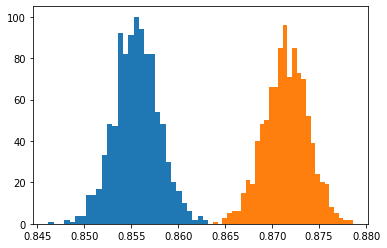

In [10]:
plt.hist(metrics_list_1, density=False, bins=30);
plt.hist(metrics_list_2, density=False, bins=30);

### ROC AUC macro
In our test set there are several different categories. It could be useful to evaluate the quality of models in each category separately, because in production we can have different binarization thresholds for different categories. In the case when different categories have different data distributions, having unique threshold for each category can drastically increase recall.

Implement ROC AUC macro metric using `sklearn.metrics.roc_auc_score`. `roc_auc_macro` should calculate ROC AUC for each category separately and then return weighted average. Weighting could be different: 
1. Weights could be equal to $\frac{1}{n\_categories}$ then the metric is the quality of the model on each category on average.
2. Weights could be proportional to categories sizes in production — then bigger categories will be more important and metric for this category will have bigger weight.
3. If we can somehow determine the weights according to business knowledge, we can use them. Actually not very realistic.

Consider the possibility of each option in your implementation. Also keep in mind that you are provided with categories of two levels: `cat2` and `cat3`. `cat3` are subcategories of `cat2`. If we have enough resources we can set thresholds for large `cat3` and get better recall than with common threshold for entire `cat2`.

In [11]:
def roc_auc_macro(real_labels, preds, cat_column, cats_weights=None):
    metrics_by_cat = dict()
    if cats_weights is not None:
        weights = []
    else:
        weights = None
    
    for cat in real_labels[cat_column].unique():
        df = real_labels[real_labels[cat_column] == cat].merge(preds, on=["product_id_1", "product_id_2"])
        metrics_by_cat[cat] = round(roc_auc_score(df.target, df.score), 4)
        
        if weights is not None:
            weights.append(cats_weights[cat])
        
    return np.average(list(metrics_by_cat.values()), weights=weights), metrics_by_cat

In [12]:
metric_1, metrics_dict_1 = roc_auc_macro(real_labels, model_v1_preds, cat_column="cat2")
metric_2, metrics_dict_2 = roc_auc_macro(real_labels, model_v2_preds, cat_column="cat2")

In [13]:
print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

ROC AUC v1: 0.8501
ROC AUC v2: 0.8666


It could be useful to look at the metric value in each category. If you have several new models and one is better in one category, another is better in another category, and you have enough resources, you can use different models for different categories in production.

In [14]:
metrics_dict_1

{'Детские товары': 0.8619,
 'Строительство и ремонт': 0.8345,
 'Товары для взрослых': 0.8246,
 'Хобби и творчество': 0.8893,
 'Дом и сад': 0.8403}

In [15]:
metrics_dict_2

{'Детские товары': 0.8794,
 'Строительство и ремонт': 0.8356,
 'Товары для взрослых': 0.8626,
 'Хобби и творчество': 0.8986,
 'Дом и сад': 0.8566}

Let's say we have category weights. Then we can calculate metric using this weights.

In [16]:
cats_weights = {
    'Детские товары': 0.1,
    'Строительство и ремонт': 0.1,
    'Товары для взрослых': 0.1,
    'Хобби и творчество': 0.2,
    'Дом и сад': 0.5
}

metric_1, metrics_dict_1 = roc_auc_macro(real_labels, model_v1_preds, cat_column="cat2", cats_weights=cats_weights)
metric_2, metrics_dict_2 = roc_auc_macro(real_labels, model_v2_preds, cat_column="cat2", cats_weights=cats_weights)

print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

ROC AUC v1: 0.8501
ROC AUC v2: 0.8658


#### * Thresholds by `cat3`

To find a reliable threshold for one category, on average, you need to mark up 250 pairs of products. Marking one pair costs 10 rubles, and for reliability three different assessors mark the same pair, so the total cost of one pair is 30 rubles. Based on this, suggest the number of `cat3` in which it is worth choosing a threshold. Suggest what to do with the rest `cat3`.

In [18]:
metric_1, _ = roc_auc_macro(real_labels, model_v1_preds, cat_column="selected_cat3")
metric_2, _ = roc_auc_macro(real_labels, model_v2_preds, cat_column="selected_cat3")

print(f"ROC AUC v1: {round(metric_1, 4)}\nROC AUC v2: {round(metric_2, 4)}")

Compare metrics with metrics averaged by `cat2` and write conclusions.

#### It also could be useful to use bootstrap in macro metric to get more reliable results. 

## Task 2. PR curve.

Implement function that builds `PR curve`. PR curve is built according to the following algorithm:
1. The first point of curve is (0, 1).
2. Dataframe is sorted in descending order of predictions.
3. Starting from the first row, we calculate the precision and recall for the current line and all that are above it. Recall values are x-coordinates of curve, precision values — y-coordinates.
4. When recall reaches 1, finish collecting the coordinates.

Function should return coordinates of curve.

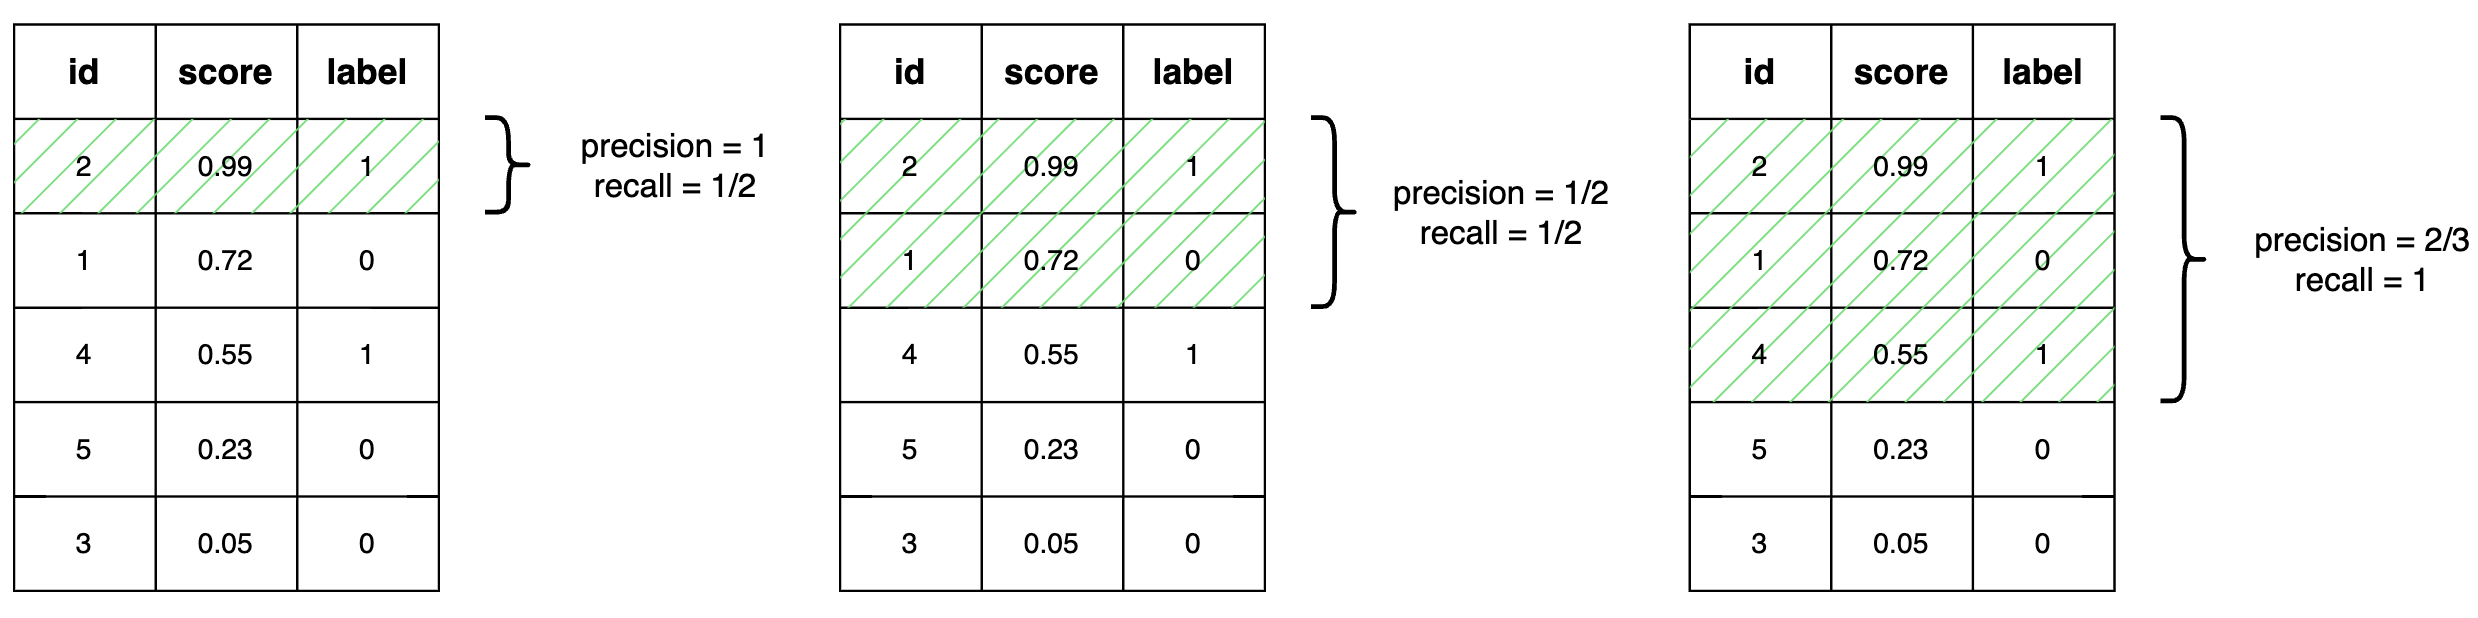

In [19]:
from typing import Tuple

def pr_curve(real_labels: pd.DataFrame, preds: pd.DataFrame) -> Tuple[np.array, np.array]:
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])
    
    # get all positives in df count for recall calculation
    positives_count = df[df.target == 1].shape[0]
    
    # sort df in descending order of predictions
    df = df.sort_values(by="score", ascending=False)
    
    # first point is (1, 0)
    precision = [1.]
    recall = [0.]
    
    i = 1
    while i <= df.shape[0]:
        if i == df.shape[0] or df.iloc[i-1]["score"] != df.iloc[i]["score"]:
            # recall
            x = df.iloc[:i]["target"].sum() / positives_count
            # precision
            y = df.iloc[:i]["target"].mean()
            
            recall.append(x)
            precision.append(y)
            
            # recall = 1
            if x == 1:
                break
            
            i += 1
        # just "scroll" rows with equal scores
        else:
            i += 1
            continue

    return np.array(precision), np.array(recall)

You can use `sklearn.metrics.auc` to calculate area under the curve. You just need to get coordinates of the points of the curve.

In [20]:
my_prec, my_rec = pr_curve(real_labels, model_v1_preds)
lib_prec, lib_rec, _ = precision_recall_curve(real_labels.target, model_v1_preds.score)
lib_prec = lib_prec[::-1]
lib_rec = lib_rec[::-1]
assert (my_prec - lib_prec).sum() == (my_rec - lib_rec).sum() == 0

### Recall (Precision = X%) / Precision (Recall = X%)
Implement function that calculates recall of a model for a certain precision and of a model for a certain recall. Compare `v1` and `v2` by these metrics.
You can use `sklearn.metrics.precision_recall_curve` to get curve coordinates.

In [21]:
def recall_at_precision(real_labels, preds, precision_lvl=0.95):
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])
    
    precision, recall, _ = precision_recall_curve(df.target, df.score)
    precision = precision[::-1]
    recall = recall[::-1]
    
    return max(recall[precision >= precision_lvl])  # == recall[precision >= precision_lvl][-1]


def precision_at_recall(real_labels, preds, recall_lvl=0.5):
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])
    
    precision, recall, _ = precision_recall_curve(df.target, df.score)
    precision = precision[::-1]
    recall = recall[::-1]
    
    return max(precision[recall >= recall_lvl])  # != precision[recall >= recall_lvl][0]

#### Recall at precision

In [22]:
print(f"v1 recall at 95% precision: {round(recall_at_precision(real_labels, model_v1_preds, precision_lvl=0.95), 4)}")
print(f"v2 recall at 95% precision: {round(recall_at_precision(real_labels, model_v2_preds, precision_lvl=0.95), 4)}")

v1 recall at 95% precision: 0.0123
v2 recall at 95% precision: 0.0551


In [23]:
print(f"v1 recall at 75% precision: {round(recall_at_precision(real_labels, model_v1_preds, precision_lvl=0.75), 4)}")
print(f"v2 recall at 75% precision: {round(recall_at_precision(real_labels, model_v2_preds, precision_lvl=0.75), 4)}")

v1 recall at 75% precision: 0.2608
v2 recall at 75% precision: 0.4179


#### Precision at recall

In [24]:
print(f"v1 precision at 50% recall: {round(precision_at_recall(real_labels, model_v1_preds, recall_lvl=0.5), 4)}")
print(f"v2 precision at 50% recall: {round(precision_at_recall(real_labels, model_v2_preds, recall_lvl=0.5), 4)}")

v1 precision at 50% recall: 0.6265
v2 precision at 50% recall: 0.7031


In [25]:
print(f"v1 precision at 30% recall: {round(precision_at_recall(real_labels, model_v1_preds, recall_lvl=0.3), 4)}")
print(f"v2 precision at 30% recall: {round(precision_at_recall(real_labels, model_v2_preds, recall_lvl=0.3), 4)}")

v1 precision at 30% recall: 0.729
v2 precision at 30% recall: 0.8193


In [26]:
v1_precision, v1_recall = pr_curve(real_labels, model_v1_preds)
v2_precision, v2_recall = pr_curve(real_labels, model_v2_preds)

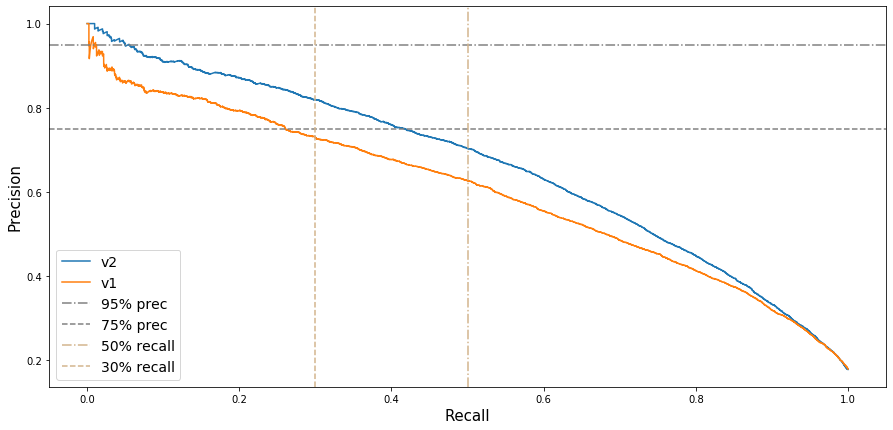

In [27]:
plt.figure(figsize=(15, 7))
plt.plot(v2_recall, v2_precision, label="v2")
plt.plot(v1_recall, v1_precision, label="v1")
plt.axhline(y=0.95, color='grey', linestyle='-.', label="95% prec")
plt.axhline(y=0.75, color='grey', linestyle='--', label="75% prec")
plt.axvline(x=0.5, color='tan', linestyle='-.', label="50% recall")
plt.axvline(x=0.3, color='tan', linestyle='--', label="30% recall")
plt.legend(fontsize=14)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15);

### PR AUC
Implement PR AUC metric, using `sklearn.metrics.precision_recall_curve` and `sklearn.metrics.auc`. Compare models.

In [28]:
def pr_auc(real_labels: pd.DataFrame, preds: pd.DataFrame) -> float:
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])

    precision, recall, _ = precision_recall_curve(df.target, df.score)
    
    return auc(recall, precision)

In [29]:
pr_auc(real_labels, model_v1_preds)

0.6004748106353489

In [30]:
pr_auc(real_labels, model_v2_preds)

0.6618172318674671

### PR AUC (Precision = X%)

In [31]:
def pr_auc_at_precision(real_labels: pd.DataFrame, preds: pd.DataFrame, precision_lvl=0.95) -> float:
    df = preds.merge(real_labels, on=["product_id_1", "product_id_2"])

    precision, recall, _ = precision_recall_curve(df.target, df.score)
    
    precision = precision[::-1]
    recall = recall[::-1]
    
    # get indices for x-coordinate (recall) where y-coordinate (precision) 
    # is higher than precision level (95% for our task)
    good_idx = np.where(precision >= precision_lvl)[0]

    # if there are more than one such x's (at least one is always there, 
    # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
    # with acceptable precision
    if len(good_idx) > 1:
        gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        
    return auc(recall[gt_prec_level_idx], precision[gt_prec_level_idx])

In [32]:
pr_auc_at_precision(real_labels, model_v1_preds)

0.011825423724835636

In [33]:
pr_auc_at_precision(real_labels, model_v2_preds)

0.05371591668203659

### PR AUC (Precision = X%) macro

In [34]:
def pr_auc_at_precision_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.95,
    cat_column: str = "cat2",
    weighted: bool = True
) -> float:

    df = target_df.merge(predictions_df, on=["product_id_1", "product_id_2"])

    y_true = df["target"]
    y_pred = df["score"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)
    metric_by_cat = dict()

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            if weighted:
                weights.append(counts[i] / len(categories))
            else:
                weights.append(1 / len(unique_cats))
            metric_by_cat[category] = 0
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            if weighted:
                weights.append(counts[i] / len(categories))
            else:
                weights.append(1 / len(unique_cats))
            metric_by_cat[category] = 0
            continue
        
        # calculate category weight anyway
        if weighted:
            weights.append(counts[i] / len(categories))
        else:
            weights.append(1 / len(unique_cats))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                metric_by_cat[category] = pr_auc_prec_level
        except ValueError:
            pr_aucs.append(0)
            metric_by_cat[category] = 0
            
    return np.average(pr_aucs, weights=weights), metric_by_cat


In [35]:
pr_auc_at_precision_macro(real_labels, model_v1_preds, weighted=False)

(0.01939596227506208,
 {'Детские товары': 0.01964183363760228,
  'Дом и сад': 0.002861230329041488,
  'Строительство и ремонт': 0.008171603677221655,
  'Товары для взрослых': 0.0006079027355623101,
  'Хобби и творчество': 0.06569724099588267})

In [36]:
pr_auc_at_precision_macro(real_labels, model_v2_preds, weighted=False)

(0.08103364376257163,
 {'Детские товары': 0.05895282030627212,
  'Дом и сад': 0.04624892243476453,
  'Строительство и ремонт': 0.07272111290161434,
  'Товары для взрослых': 0.05753678879586697,
  'Хобби и творчество': 0.16970857437434023})